In [1]:

# 注意
# 当前使用的Pandas需要版本为1.4.3, 高版本在数据清洗的时候会报错

# 降及 pandas 到 1.4.3
# 参考: https://github.com/d2l-ai/d2l-en/pull/2545
# zh项目: https://github.com/d2l-ai/d2l-zh/blob/master/chapter_multilayer-perceptrons/kaggle-house-price.md


In [2]:
%matplotlib inline
# from d2l import torch as d2l
import torch
from torch import nn
import pandas as pd
import numpy as np

import sys
sys.path.append("..")
import d2lzh_pytorch.torch_package as d2l

print(torch.__version__)

P:\python\anaconda3\envs\d2l_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.0.1+cu118


In [3]:
import os

# 原始数据下载: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

root_path = "/home/mylady/ai_data/kaggle_house"

root_path = r"X:\big_ai_files\d2l_data\kaggle_house"


p1 = os.path.join(root_path, "train.csv")
p2 = os.path.join(root_path, "test.csv")


train_data = pd.read_csv(p1)
test_data = pd.read_csv(p2)

# 训练数据集包括1460个样本，每个样本80个特征和1个标签，
# 而测试数据集包含1459个样本，每个样本80个特征。

In [4]:
print(train_data.shape)
print(test_data.shape)


(1460, 81)
(1459, 80)


让我们看看前四个和最后两个特征，以及相应标签（房价）。

In [5]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


我们可以看到，在每个样本中，第⼀个特征是ID，这有助于模型识别每个训练样本。虽然这很⽅便，但它不
携带任何⽤于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [6]:
train_data.iloc[:, 1:-1].shape

(1460, 79)

In [7]:
test_data.iloc[:, 1:].shape

(1459, 79)

In [10]:

all_features = pd.concat((
    train_data.iloc[:, 1:-1], 
    test_data.iloc[:, 1:])
)

In [11]:
all_features.shape


(2919, 79)

In [12]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [ ]:
all_features

In [13]:
#@tab all
# 若无法获得测试数据，则可根据训练数据计算均值和标准差

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [14]:


all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))


# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

我们可以看到，在每个样本中，第⼀个特征是ID，这有助于模型识别每个训练样本。虽然这很⽅便，但它不
携带任何⽤于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除。


In [15]:
#@tab all
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, 
                              dummy_na=False)

# 注意pandas的版本, 能用的 pip install pandas==1.5.*

In [16]:
all_features.shape

(2919, 288)

In [17]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,0,0,1,0,0,0,0,1,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,0,0,1,0,0,0,0,1,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,0,0,1,0,0,0,0,1,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,0,0,1,1,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,0,0,1,0,0,0,0,1,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,0,0,1,1,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,0,0,1,1,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,0,0,1,0,0,0,0,1,0


In [18]:
n_train = train_data.shape[0]

In [ ]:
n_train

In [19]:


print(all_features[:n_train].values)



[[ 0.06731988 -0.18444262 -0.21784137 ...  0.          1.
   0.        ]
 [-0.87346638  0.45809588 -0.07203174 ...  0.          1.
   0.        ]
 [ 0.06731988 -0.05593492  0.13717338 ...  0.          1.
   0.        ]
 ...
 [ 0.30251644 -0.14160672 -0.14278111 ...  0.          1.
   0.        ]
 [-0.87346638 -0.05593492 -0.0571972  ...  0.          1.
   0.        ]
 [-0.87346638  0.24391638 -0.02930318 ...  0.          1.
   0.        ]]


In [20]:
all_features.shape


(2919, 288)

In [21]:
#@tab all
n_train = train_data.shape[0]


# torch.float32
# torch.float64

a1 = all_features[:n_train].values
a2 = all_features[n_train:].values

# 强制类型转换
# a1.astype(float)
# a2.astype(float)

train_features = d2l.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = d2l.tensor(all_features[n_train:].values, dtype=d2l.float32)

# 降及 pandas 到 1.4.3
# 参考: https://github.com/d2l-ai/d2l-en/pull/2545
# zh项目: https://github.com/d2l-ai/d2l-zh/blob/master/chapter_multilayer-perceptrons/kaggle-house-price.md

In [22]:

train_labels = d2l.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)

In [23]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [24]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [25]:
#@tab pytorch
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [26]:
#@tab all
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = d2l.concat([X_train, X_part], 0)
            y_train = d2l.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [27]:
#@tab all
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.368354, 验证log rmse0.204957
折2，训练log rmse0.228814, 验证log rmse0.648016
折3，训练log rmse0.358983, 验证log rmse0.212248
折4，训练log rmse0.367977, 验证log rmse0.178135
折5，训练log rmse0.364041, 验证log rmse0.240351
5-折验证: 平均训练log rmse: 0.337634, 平均验证log rmse: 0.296741


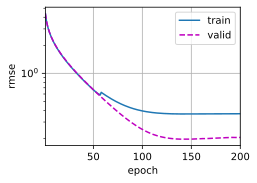

In [28]:
#@tab all
# 超参数设置
k = 5
num_epochs = 200
lr = 3

weight_decay = 0.1
batch_size = 64


train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)


print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [29]:
import datetime


In [30]:
#@tab all
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    
    # 将网络应用于测试集。
    preds = d2l.numpy(net(test_features))
    
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
        
    str_time = str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    submission.to_csv('submission_%s.csv' % str_time, index=False)

训练log rmse：0.334230


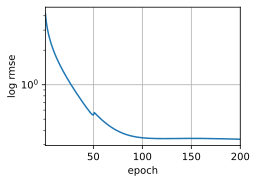

In [31]:

# 训练并预测
train_and_pred(train_features, test_features, 
               train_labels, test_data,
               num_epochs, 
               lr, 
               weight_decay,
               batch_size)

In [ ]:

# 平均误差 30%
